# Градиентный бустинг над решающими деревьями

###### Импорт необходимых библиотек

In [105]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

###### Импорт датасета и преобразование данных

In [2]:
df = pd.read_csv('gbm-data.csv')

In [8]:
df.head(5)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Преобразование признаков и целевой переменной в numpy массивы
X = df.iloc[:, 1:].values
y = df['Activity'].values

###### Обучение градиентного бустинга при различных коэффициентах обучения

In [21]:
# Разбиение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [16]:
# Функция сигмоиды для использования в последующем обучении
def sigmoid(y_pred):
    return 1 / (1 + np.exp(-y_pred))

In [43]:
# Обучение при различных learning_rates
learning_rates = [1, 0.5, 0.3, 0.2, 0.1]
# Создание словарей для записей log-loss оценок при различных learning_rates
log_los_scores_train = dict()
log_los_scores_test = dict()
# Процесс обучения и оценка качества на каждой итерации для обучающей и тестовой выборок
for rate in learning_rates:
    train_scores = list(range(250))
    test_scores = list(range(250))
    print("\033[1m" + f'Learning Rate = {rate}' + "\033[0m")
    GradBoost = GradientBoostingClassifier(n_estimators=250, learning_rate=rate, verbose=True, random_state=241)
    GradBoost.fit(X_train, y_train)
    for i, predictions in enumerate(GradBoost.staged_decision_function(X_train)):
        predictions = [y_pred[0] for y_pred in predictions.tolist()]
        predictions = [sigmoid(y_pred) for y_pred in predictions]
        train_scores[i] = log_loss(y_train, predictions)
    log_los_scores_train[rate] = train_scores[:]
    for i, predictions in enumerate(GradBoost.staged_decision_function(X_test)):
        predictions = [y_pred[0] for y_pred in predictions.tolist()]
        predictions = [sigmoid(y_pred) for y_pred in predictions]
        test_scores[i] = log_loss(y_test, predictions)
    log_los_scores_test[rate] = test_scores[:]

Learning Rate = 1
      Iter       Train Loss   Remaining Time 
         1           1.0190           34.27s
         2           0.9192           32.03s
         3           0.8272           30.71s
         4           0.7834           30.61s
         5           0.7109           30.27s
         6           0.6368           30.88s
         7           0.5797           31.62s
         8           0.5610           31.45s
         9           0.5185           30.86s
        10           0.4984           30.82s
        20           0.1999           27.80s
        30           0.1313           26.18s
        40           0.0790           24.93s
        50           0.0511           24.49s
        60           0.0352           23.51s
        70           0.0245           23.18s
        80           0.0162           22.02s
        90           0.0114           20.95s
       100           0.0077           19.62s
       200           0.0002            6.02s
Learning Rate = 0.5
      Iter      

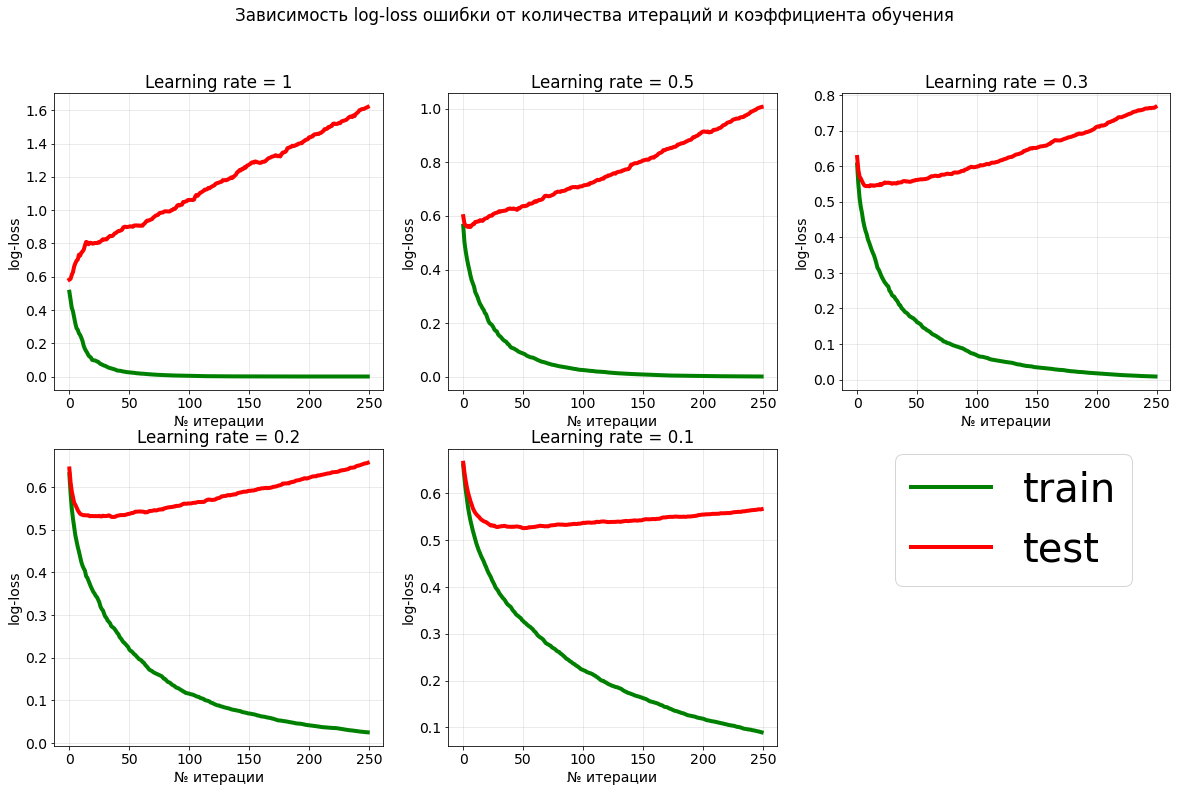

In [98]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size':14.0})
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.plot(list(range(250)), log_los_scores_train[learning_rates[i]], 'g', lw=4.0)
    plt.plot(list(range(250)), log_los_scores_test[learning_rates[i]], 'r', lw=4.0)
    plt.grid(alpha=0.3)
    plt.xlabel('№ итерации')
    plt.ylabel('log-loss')
    plt.title(f'Learning rate = {learning_rates[i]}')
plt.legend(['train', 'test'], bbox_to_anchor=(1.3, 1.05), prop={'size': 40})
plt.suptitle('Зависимость log-loss ошибки от количества итераций и коэффициента обучения')
plt.show()

Таким образом, отчетливо заметно, что при выборе коэффициента обучения (Learning rate), представляющего собой коэффициент веса каждого отдельного алгоритма в композиции, ошибка log-loss гораздо медленнее повышается на тестовой выборке и принимает меньшие значения, нежели чем при иных коэффициентах. Тем не менее, __сохраняется общая тендеция переобучения__ вне зависимости от выбора коэффициента.

In [104]:
# Нахождение наименьшего значения log-loss и № итерации при learning rate = 0.2
print('Наименьшее значение log-loss при learning rate = 0.2:', round(np.min(log_los_scores_test[0.2]), 2))
print('Номер итерации, при которой было найдено наименьшее значение log-loss:', np.argmin(log_los_scores_test[0.2]) + 1)

Наименьшее значение log-loss при learning rate = 0.2: 0.53
Номер итерации, при которой было найдено наименьшее значение log-loss: 37


###### Обучение случайного леса и сравнение с градиентным бустингом

In [106]:
# Обучение случайного леса с числом деревьев, равным числу деревьев из модели градиентного бустинга при 0.2 коэффициенте
RandForest = RandomForestClassifier(n_estimators=37, random_state=241)
RandForest.fit(X_train, y_train)
log_loss_forest = log_loss(y_test, RandForest.predict_proba(X_test))

In [111]:
print('Ошибка log-loss случайного леса с числом деревьев, равным 37:', round(log_loss_forest, 2))

Ошибка log-loss случайного леса с числом деревьев, равным 37: 0.54


Таким образом, следует отметить, что случайный лес при том же количестве деревьев получает несколько большую ошибку, нежели чем при использовании градиентного бустинга.

Рассмотрим, как будет меняться качество композиции при увеличении числа деревьев случайного леса.

In [121]:
n_trees = [100, 250, 300, 400, 500, 1000]
scores_forest = []
for tree in n_trees:
    RandForest = RandomForestClassifier(n_estimators=tree, random_state=241)
    RandForest.fit(X_train, y_train)
    scores_forest.append(log_loss(y_test, RandForest.predict_proba(X_test)))

In [122]:
print('Наименьшая ошибка log-loss случайного леса:', round(np.min(scores_forest), 2))
print('Количество деревьев, при котором достигнута ошибка:', 
      n_trees[np.argmin(scores_forest)])

Наименьшая ошибка log-loss случайного леса: 0.52
Количество деревьев, при котором достигнута ошибка: 1000


То есть, с увеличением количества деревьев ошибка будет продолжать падать, хотя и незначительно. При $1000$ деревьях удалось минимизировать ошибку еще на $0.01$.